In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from seq_draw import rf_pulses, atoms, gradients, misc, overlays, SeqDiagram, seq_blocks


def get_mrm_figsize(aspect, option='single'):
    fig_size_single_column = 3.42  # [inches]
    fig_size_oneandhalf = 5.125
    fig_size_double_column =6.92
    fig_size = (0, 0)
    if option == 'single':
        fig_size = (fig_size_single_column, aspect*fig_size_single_column)
    elif option == 'oneandhalf':
        fig_size = (fig_size_oneandhalf, aspect*fig_size_oneandhalf)
    elif option == 'double':
        fig_size = (fig_size_double_column, aspect*fig_size_double_column)
    return fig_size

import itertools
import json
from scipy.spatial import Voronoi
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_sampling(filename, ax, cax, arrow_size=3):
    sampling_file = filename
    sampling = json.load(open(sampling_file))
    sampling['line_ids'] = np.array(sampling['line_ids']) - 1
    
    # draw axes
    arrow_off = -1.
    arrow_width = 0.15
    arrow_kw = {'verticalalignment': 'center', 'horizontalalignment': 'left', 'size': 'small'}
    ax.arrow(arrow_off, arrow_off, arrow_size, 0, width=arrow_width, facecolor='black', length_includes_head=True)
    ax.text(arrow_off + arrow_size + arrow_width, arrow_off - arrow_width, '$k_{PE1}$', fontdict=arrow_kw)
    arrow_kw['verticalalignment'] = 'bottom'
    arrow_kw['horizontalalignment'] = 'center'
    ax.arrow(arrow_off, arrow_off, 0, arrow_size, width=arrow_width, facecolor='black', length_includes_head=True)
    ax.text(arrow_off - arrow_width, arrow_off + arrow_size + arrow_width, '$k_{PE2}$', fontdict=arrow_kw, rotation='vertical')

    points = np.array(zip(sampling['line_ids'], sampling['partition_ids']))
    # print points
    vor = Voronoi(points)
    measured_points = sampling['SamplingInfo']['TotalNumberOfKSpacePoints']
    lines = sampling['SamplingInfo']['NumberOfLines']
    partitions = sampling['SamplingInfo']['NumberOfPartitions']
    blade_segments_lin = sampling['SamplingParams']['BladeSegmentsLin']
    blade_segments_par = sampling['SamplingParams']['BladeSegmentsPar']
    pat_factor_par = sampling['SamplingParams']['PartitionsPATFactor']
    pat_factor_lin = sampling['SamplingParams']['LinesPATFactor']
    line_ids = np.array(sampling['line_ids'])
    partition_ids = np.array(sampling['partition_ids'])

    # defione TF/EF
    tf = partitions*blade_segments_par/(pat_factor_par)
    ef = lines/(pat_factor_lin*blade_segments_lin)
    nex = lines / (ef * pat_factor_lin)
    print 'Turbofactor={0} EPI-Factor={1}'.format(tf,ef)
    print 'tf=', tf
    print 'ef=', ef
    print 'nex=',nex

    # create grid
    X,Y = np.meshgrid(np.arange(0, sampling['SamplingInfo']['NumberOfLines']), 
                      np.arange(sampling['SamplingInfo']['NumberOfPartitions']-1, -1, -1))

    markers = ['s', 'D']
    marker_size = 20
    virdis = plt.cm.get_cmap('viridis')
    # get inidces
    ind = np.where((line_ids % 4 == 0))
    ind2 = np.where((line_ids % 4 != 0))
    # calculate eff epi-factor
    ef1 = len(ind[0])/tf
    ef2 = len(ind2[0])/tf
    # create colors
    colors1 = [[virdis(_i)] * ef1 for _i in np.linspace(0., 1., tf)]
    colors2 = [[virdis(_i)] * ef2 for _i in np.linspace(0., 1., tf)]
    # flatten list of lists
    colors1 = list(itertools.chain.from_iterable(colors1))
    colors2 = list(itertools.chain.from_iterable(colors2))


    # draw trajectory
    for _j in range(nex):
        for _i in range(tf):
    #         if _i in {2}:
            trajectory = ax.plot(points[_i*ef:(_i+1)*ef,0], points[_i*ef:(_i+1)*ef,1], '-', color=colors1[_i*ef1], alpha=0.5)

    # plot gray crosses
    ks = ax.scatter(X,Y, c='gray', alpha=0.5, marker='x', s=0.5*marker_size)
    
    # plot sampled points
    samp1 = ax.scatter(line_ids[ind], partition_ids[ind], c=colors1, s=marker_size, marker=markers[0], vmin=0., vmax=1.)
    samp2 = ax.scatter(line_ids[ind2], partition_ids[ind2], c=colors2, s=marker_size, marker=markers[1])
    # set lims
    _sampling_edge_lin = 1.
    _sampling_edge_par = 1.
#     plt.xlim(-1.5, 30)
#     plt.ylim(-1.5, 14)
#     plt.xlim(-_sampling_edge_lin, lines + _sampling_edge_lin - 1)
#     plt.ylim(partitions - 1 + _sampling_edge_par, -_sampling_edge_par)
    plt.ylabel('PartitionId [#]')
    plt.xlabel('LineId [#]')
    if not (cax is None):
        cmap = mpl.cm.viridis
        norm = mpl.colors.Normalize(vmin=0, vmax=1)
        bounds = np.linspace(0., 1., tf-1, endpoint=False)
        bounds = [-10] + list(bounds) + [10]
        cb1 = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap,
                                        norm=norm,
                                        boundaries=bounds,
                                        ticks=[bounds[0], bounds[-1]],
                                        orientation='vertical')
        cb1.set_label('spin echo', labelpad=-20)
        cb1.ax.set_yticklabels(['early', 'late'])

import copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=get_mrm_figsize(.7, option='double'))
grid = gridspec.GridSpec(2, 3, width_ratios=[6,6,1], height_ratios=[4,3])
plt.subplots_adjust(hspace=0.075, wspace=0.)

ax1 = plt.subplot(grid[1,0])
ax1.axes.set_frame_on(False)
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
cax = plt.subplot(grid[1,2])
cax.axes.set_frame_on(False)
cax.axes.get_xaxis().set_visible(False)
# cax.axes.get_yaxis().set_visible(False)
plot_sampling('./GRAPPA.json', ax1, cax)
ax1.set_ylim(-2, None)
ax2 = plt.subplot(grid[1,1])
ax2.axes.set_frame_on(False)
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
plot_sampling('./CAIPI.json', ax2, None)
ax2.set_ylim(-2, None)

ax = plt.subplot(grid[0,:])
ax.axes.set_frame_on(False)

# init sequence diagram
sd = SeqDiagram(ax=ax)

# inti with useful start values
sd.init_axes()
print sd.sqaxes.keys()

# internally axes are dictionarys which store elemnts in a list (key=atoms)
print sd.sqaxes['rf']

# define draw style
std_kw = {'linestyle': 'solid', 'color': 'black', 'linewidth': .5}
std_bold = copy.copy(std_kw)
std_bold['linewidth'] = 1.0
std_dashed = copy.copy(std_kw)
std_dashed['linestyle'] = 'dashed'
rf_kw = copy.copy(std_kw)
grad_kw = copy.copy(std_kw)
grad_kw_dashed = copy.copy(grad_kw)
grad_kw_dashed['linestyle'] = 'dashed'
epi_kw = copy.copy(grad_kw)
# epi_kw['alpha'] = 0.5
epi_caipi_kw = copy.copy(grad_kw)
epi_caipi_kw['color'] = 'red'
epi_caipi_kw['linestyle'] = 'dotted'
vline_kw = copy.copy(std_kw)
vline_kw['linewidth'] = .5
vline_kw['linestyle'] = 'dashed'
span_yoff = 0.925
arrow_kw={'head_width': 0.02, 'head_length': 0.05, 'color': 'black'}

# define times
start_delay = 0.75
echo_time = 5.0
nref = 1
rf_pulse_dur = 0.25
rf_intensity = 0.1
rf_int_wet = 0.15
grad_read_dur = 0.1
grad_read_int = 0.025
grad_blip_dur = 0.05
crush_dur = 0.1
crush_int = 3*grad_read_int
enc_dur = grad_read_dur
enc_int = 0.05
nav_rep = 3
epi_rep = 9

## --- Create pulse objects ---

# use fa scalefactors from WET publication
wet_scaling = [(81.4**0.5)/(161.0**0.5), (101.4**0.5)/(161.0**0.5), (69.0**0.5)/(161.0**0.5), (161.0**0.5)/(161.0**0.5)]
wet1 = rf_pulses.SincPulse(sd, 'rf', rf_pulse_dur, rf_int_wet*wet_scaling[0], side_lobes=5, plot_kw=rf_kw)
wet2 = rf_pulses.SincPulse(sd, 'rf', rf_pulse_dur, rf_int_wet*wet_scaling[1], side_lobes=5, plot_kw=rf_kw)
wet3 = rf_pulses.SincPulse(sd, 'rf', rf_pulse_dur, rf_int_wet*wet_scaling[2], side_lobes=5, plot_kw=rf_kw)
wet4 = rf_pulses.SincPulse(sd, 'rf', rf_pulse_dur, rf_int_wet*wet_scaling[3], side_lobes=5, plot_kw=rf_kw)
wet_slisel = gradients.RectGrad(sd, 'gz', rf_pulse_dur, 0.5*grad_read_int, plot_kw=grad_kw)
wet_spoil = gradients.RectGrad(sd, 'gz', rf_pulse_dur/2, -2*grad_read_int, plot_kw=grad_kw)
wet_delta_spoil = misc.Line(sd, 'gz', rf_pulse_dur/2, plot_kw=grad_kw)
wet_rf = [wet1, wet_delta_spoil, wet2, wet_delta_spoil, wet3, wet_delta_spoil, wet4, wet_delta_spoil]
wet_rf = [wet1, wet_delta_spoil]
wet_gz = [wet_slisel, wet_spoil] #* 4

# PCASL
pcasl_rep = 4
pcasl_int = 0.05
pcasl_rf_dur = 0.125
pcasl_ss_dur = 2 * pcasl_rf_dur
pcasl_ss = gradients.TrapGrad(sd, 'gz', pcasl_ss_dur, 0.5*grad_read_int, plot_kw=grad_kw)
pcasl_ssi = gradients.TrapGrad(sd, 'gz', pcasl_ss_dur/2, -grad_read_int, plot_kw=grad_kw)
pcasl_rf_pulse = rf_pulses.HanningPulse(sd, 'rf', pcasl_rf_dur, pcasl_int, plot_kw=rf_kw)
pcasl_rf_space = misc.Line(sd, 'rf', pcasl_rf_dur/2, plot_kw=std_kw)
pcasl_rf_element = [pcasl_rf_space, pcasl_rf_pulse, pcasl_rf_space, pcasl_rf_space, pcasl_rf_space]
pcasl_gz_element = [pcasl_ss, pcasl_ssi]
pcasl_delay = misc.Line(sd, 'gz', sd.get_total_duration(pcasl_rf_element), plot_kw=std_dashed)
pcasl_rf =  pcasl_rf_element * int(pcasl_rep/2) + [pcasl_delay] + pcasl_rf_element * (pcasl_rep - (int(pcasl_rep/2) + 1))
pcasl_gz =  pcasl_gz_element * int(pcasl_rep/2) + [pcasl_delay] + pcasl_gz_element * (pcasl_rep - (int(pcasl_rep/2) + 1))

# Background suppression
bs_pulse_dur = 0.25
bs_int = 0.125
bs_rf_pulse = rf_pulses.HyperbolicSecantPulse(sd, 'rf', bs_pulse_dur, bs_int, plot_kw=rf_kw)
bs_ss_dur = 2 * bs_pulse_dur
bs_spoil_dur = bs_pulse_dur
bs_spoil_int = 0.075
bs_ss = gradients.TrapGrad(sd, 'gz', bs_ss_dur, grad_read_int*0.5, plot_kw=grad_kw)
bs_spoil = gradients.TrapGrad(sd, 'gz', bs_spoil_dur, bs_spoil_int, plot_kw=grad_kw)
bs_del = misc.Line(sd, 'rf', bs_pulse_dur/2, plot_kw=std_kw)
bs_intrr = misc.Interruption(sd, 'rf', bs_pulse_dur, 0.025, plot_kw=std_kw)
bs_rf = [bs_intrr, bs_del, bs_rf_pulse, [bs_del] * 3, bs_intrr]
bs_gxy = [bs_intrr, [bs_del] * 6, bs_intrr]
bs_gz = [bs_intrr, bs_ss, bs_spoil, bs_intrr]

## GRASE
# rf pulses
exc = rf_pulses.SincPulse(sd, 'rf', rf_pulse_dur, rf_intensity, label=u'90˚', side_lobes=6, plot_kw=rf_kw)
ref = rf_pulses.SincPulse(sd, 'rf', rf_pulse_dur, 1.5*rf_intensity, label=u'180˚', label_coord=(-0.125, 0.15), plot_kw=rf_kw)

# gradients
slab_sel = gradients.RectGrad(sd, 'gz', rf_pulse_dur, grad_read_int, plot_kw=grad_kw)
slab_sel_reph = gradients.RectGrad(sd, 'gz', rf_pulse_dur/2, -grad_read_int*2, plot_kw=grad_kw)
crush_grad = gradients.RectGrad(sd, 'gz', crush_dur, crush_int, plot_kw=grad_kw)
read_enc = gradients.TrapGrad(sd, 'gx', enc_dur, grad_read_int * 0.5, plot_kw=grad_kw)
pe1_enc = gradients.TrapGrad(sd, 'gy', enc_dur, -grad_read_int*1.5, plot_kw=grad_kw)
pe2_enc = gradients.TrapGradTable(sd, 'g2', enc_dur, enc_int, -enc_int, tab_type=gradients.GradTableType.CENTER_OUT,
                                  ft_ramp_ratio=1., plot_kw=grad_kw, draw_arrow=False)
# navigators
pc_scans = seq_blocks.get_epi_readout(sd, 'gy', nav_rep, grad_read_dur, grad_read_int, read_grad=slab_sel, plot_kw=grad_kw)

# EPI readout
epi_read = seq_blocks.get_epi_readout(sd, 'gx', epi_rep, grad_read_dur, grad_read_int, read_grad=pe1_enc, plot_kw=grad_kw)
blip = gradients.BlipGrad(sd, 'gy', grad_blip_dur, grad_read_int, plot_kw=grad_kw)
blip_grappa = gradients.BlipGrad(sd, 'gy', grad_blip_dur, grad_read_int, plot_kw=epi_kw)
blip_caipi = gradients.BlipGrad(sd, 'gy', grad_blip_dur, grad_read_int, plot_kw=epi_caipi_kw)
epi_pe1 = seq_blocks.get_epi_blips(sd, 'gy', epi_rep - 1, grad_blip_dur, grad_read_int*1.5, grad_read_dur, blip_grad=blip, blip_pattern=[1.0], plot_kw=grad_kw)
epi_pe2 = seq_blocks.get_epi_blips(sd, 'gz', epi_rep - 1, grad_blip_dur, grad_read_int, grad_read_dur, blip_pattern=[1.], blip_grad=blip_grappa, plot_kw=epi_kw)
epi_pe2_CAIPI = seq_blocks.get_epi_blips(sd, 'gz', epi_rep - 1, grad_blip_dur, grad_read_int, grad_read_dur, blip_pattern=[1., -1.], blip_grad=blip_caipi, plot_kw=epi_caipi_kw)

# define some time spans
delta = misc.Line(sd, 'rf', 0.5, plot_kw=std_kw)
delta_rf = misc.Line(sd, 'gy', rf_pulse_dur, plot_kw=std_kw)
delta_crush = misc.Line(sd, 'rf', crush_dur, plot_kw=std_kw)

# define some useful elements
refocusing_rf = [delta_crush, ref, delta_crush]
refocusing_gxy = [crush_grad, delta_rf, crush_grad]
refocusing_gz = [crush_grad, slab_sel, crush_grad]

# --- Timing ---

wet_duration = sd.get_total_duration(wet_rf)
pcasl_dur = sd.get_total_duration(pcasl_rf)
bs_dur = sd.get_total_duration(bs_rf)
epi_duration = sd.get_total_duration(epi_read)
refocusing_duration = sd.get_total_duration(refocusing_rf)
echo_time = 2. * (epi_duration/2 + refocusing_duration/2 + enc_dur)
wet_start_time = start_delay
pcasl_start_time = wet_start_time + wet_duration
bs_start_time = pcasl_start_time + pcasl_dur
exc_center_time = bs_start_time + bs_dur + rf_pulse_dur/2

## --- Draw sequence ---

## Add pulses to axes
sd.fill(tp=start_delay, plot_kw=std_kw)
# presaturation
sd.add_atom(sd.set_axis(wet_rf, 'rf'))
sd.add_atom(sd.set_axis(wet_gz, 'gz'))
sd.fill(plot_kw=std_kw)
# pcasl
sd.add_atom(sd.set_axis([pcasl_rf], 'rf'))
sd.add_atom(sd.set_axis([pcasl_gz], 'gz'))
sd.fill(plot_kw=std_kw)
# bs
sd.add_atom(sd.set_axis([bs_rf], 'rf'))
sd.add_atom(sd.set_axis([bs_gxy], 'gx'))
sd.add_atom(sd.set_axis([bs_gxy], 'gy'))
sd.add_atom(sd.set_axis([bs_gz], 'gz'))
sd.fill(plot_kw=std_kw)
# Start with excitation and navigators
sd.add_atom(sd.set_axis([exc], 'rf'))
sd.add_atom(sd.set_axis([delta_rf], 'gx'))
sd.add_atom(sd.set_axis([delta_rf, misc.Line(sd, 'gy', rf_pulse_dur/2, plot_kw=std_kw), pc_scans], 'gy'))
sd.add_atom(sd.set_axis([slab_sel, slab_sel_reph], 'gz'))
sd.fill(axes=['rf','gx', 'gy', 'gz'], tp=start_delay + wet_duration + pcasl_dur + bs_dur + rf_pulse_dur/2 + echo_time/2 - crush_dur - rf_pulse_dur/2, plot_kw=std_kw)
# refocusing and EPI trajectory
sd.add_atom(sd.set_axis(refocusing_rf, 'rf'))
sd.add_atom(sd.set_axis([refocusing_gxy, read_enc, epi_read,read_enc], 'gx'))
sd.add_atom(sd.set_axis([refocusing_gxy, pe1_enc, epi_pe1,pe1_enc], 'gy'))
sd.add_atom(sd.set_axis([refocusing_gz, pe2_enc, epi_pe2,pe2_enc], 'gz'))
sd.fill(plot_kw=std_kw)
# 2nd refocusing
sd.add_atom(sd.set_axis(refocusing_rf, 'rf'))
sd.add_atom(sd.set_axis(refocusing_gxy, 'gx'))
sd.add_atom(sd.set_axis(refocusing_gxy, 'gy'))
sd.add_atom(sd.set_axis(refocusing_gz, 'gz'))
sd.fill(plot_kw=std_kw)
sd.fill(tp=sd.get_total_duration(sd.sqaxes['rf']['atoms']) + 0.25, plot_kw=std_dashed)

## --- Add overlay elements ---

# add echo time arrow
te_span = overlays.TimeSpan(sd, exc_center_time, echo_time, span_yoff, 'TE', arrow_kw=arrow_kw)
te_span.draw()
vline1 = overlays.VerticalLine(sd, exc_center_time, plot_kw=vline_kw, ymax=span_yoff)
vline1.draw()
vline2 = overlays.VerticalLine(sd, exc_center_time + echo_time, plot_kw=vline_kw, ymax=span_yoff)
vline2.draw()
vline3 = overlays.VerticalLine(sd, pcasl_start_time, plot_kw=vline_kw, ymax=span_yoff)
vline3.draw()
vline4 = overlays.VerticalLine(sd, bs_start_time, plot_kw=vline_kw, ymax=span_yoff)
vline4.draw()
pld_span = overlays.TimeSpan(sd, bs_start_time, bs_dur + rf_pulse_dur/2, span_yoff, 'PLD', arrow_kw=arrow_kw)
pld_span.draw()
pld_span = overlays.TimeSpan(sd, pcasl_start_time, pcasl_dur, span_yoff, 'LD', arrow_kw=arrow_kw)
pld_span.draw()

# Shaded areas
wet_area = overlays.VerticalSpan(sd, wet_start_time, wet_start_time + wet_duration, plot_kw={'color': 'green'})
wet_area.draw()
pcasl_area = overlays.VerticalSpan(sd, pcasl_start_time, pcasl_start_time + pcasl_dur)
pcasl_area.draw()
bs_area = overlays.VerticalSpan(sd, bs_start_time + bs_intrr.duration, bs_start_time + bs_dur, plot_kw={'color': 'green'})
bs_area.draw()

# Brackets around WET
wet_bra = overlays.Bra(sd, wet_start_time, xlen=0.1, plot_kw=std_bold)
wet_ket = overlays.Ket(sd, wet_start_time + wet_duration, xlen=0.1, plot_kw=std_bold)
wet_bra.draw()
wet_ket.draw()

# Brackets around BS
bs_bra = overlays.Bra(sd, bs_start_time + bs_intrr.duration, xlen=0.1, plot_kw=std_bold)
bs_ket = overlays.Ket(sd, bs_start_time + bs_dur, xlen=0.1, plot_kw=std_bold)
bs_bra.draw()
bs_ket.draw()

# manually draw 2nd pe
sd.sqaxes['gz']['offset_x'] = exc_center_time + echo_time/2 + rf_pulse_dur/2 + crush_dur + enc_dur
for at in epi_pe2_CAIPI:
    at.draw()
sd.sqaxes['gz']['offset_x'] = sd.sqaxes['gz']['offset_x_init']

# draw
sd.draw(debug=False)



# save

fig.savefig('3DGRASE.pdf', bbox_inches='tight')

In [123]:
# SeqDiagram shows all axes with its elements when printed
sd

Axis rf:
  0.000: AxisLabel(Axis='rf', duration=0.50)
  0.500: Line(Axis='rf', duration=0.25)
  0.750: SincPulse(Axis='rf', duration=0.25)
  1.000: Line(Axis='rf', duration=0.12)
  1.125: Line(Axis='rf', duration=0.06)
  1.188: HanningPulse(Axis='rf', duration=0.12)
  1.312: Line(Axis='rf', duration=0.06)
  1.375: Line(Axis='rf', duration=0.06)
  1.438: Line(Axis='rf', duration=0.06)
  1.500: Line(Axis='rf', duration=0.06)
  1.562: HanningPulse(Axis='rf', duration=0.12)
  1.688: Line(Axis='rf', duration=0.06)
  1.750: Line(Axis='rf', duration=0.06)
  1.812: Line(Axis='rf', duration=0.06)
  1.875: Line(Axis='rf', duration=0.38)
  2.250: Line(Axis='rf', duration=0.06)
  2.312: HanningPulse(Axis='rf', duration=0.12)
  2.438: Line(Axis='rf', duration=0.06)
  2.500: Line(Axis='rf', duration=0.06)
  2.562: Line(Axis='rf', duration=0.06)
  2.625: Interruption(Axis='rf', duration=0.25)
  2.875: Line(Axis='rf', duration=0.12)
  3.000: HyperbolicSecantPulse(Axis='rf', duration=0.25)
  3.250: Lin

<class 'matplotlib.colorbar.Colorbar'>


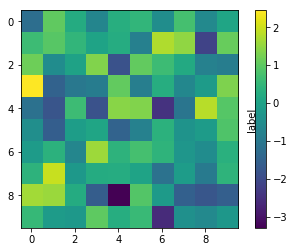

In [5]:
import numpy as np
import matplotlib.pylab as plt 

ax = plt.subplot(111)
dat = np.random.randn(10,10)
im = ax.imshow(dat, interpolation='none')
clb = plt.colorbar(im)
clb.set_label('label', labelpad=-40)
print type(clb)
plt.show()

In [6]:
from mpl_toolkits.axes_grid1.axes_grid import Colorbar

In [7]:
ax = plt.subplot(111)
cb = Colorbar(mappable=im, ax=ax)
print cb.ax.bbox.transformed(gcf().transFigure)
cb.

SyntaxError: invalid syntax (<ipython-input-7-a93ebe0fcffa>, line 4)

In [ ]:
import nibabel as nib
from mpl_toolkits.axes_grid1 import ImageGrid, AxesGrid
from matplotlib.offsetbox import AnchoredText, AnchoredOffsetbox
from matplotlib.patheffects import withStroke
from scipy.ndimage.filters import sobel
from skimage import feature
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import numpy as np
import matplotlib.pylab as plt
import matplotlib

In [ ]:
fig = plt.figure()
gr = ImageGrid(fig, 111, nrows_ncols=(2,2))
el0 = gr[0]

pos = (0.25, .25)
print plt.text(pos[0], pos[1], 'test')
print el0.get_axes().transAxes.transform(pos)
print gr[1].axes.transAxes.transform(pos)